In [1]:
# 1. Bibliotekų importavimas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import requests
from datetime import datetime, timedelta
import joblib
import os

# Nustatome grafikų stilių
plt.style.use('ggplot')

In [2]:
# 2. Duomenų gavimas iš Binance API
# Naudojame tą pačią funkciją, kaip ir ankstesniuose modeliuose

def gauti_bitcoin_duomenis(dienu_skaicius=365):
    """
    Gauna Bitcoin kainos duomenis per pasirinktą dienų skaičių iš Binance
    
    Args:
        dienu_skaicius: Kiek praeities dienų įtraukti
    
    Returns:
        pandas DataFrame su kainų duomenimis
    """
    # Apskaičiuojame pradžios laiko žymą (timestamp) milisekundėmis
    pabaigos_data = datetime.now()
    pradzios_data = pabaigos_data - timedelta(days=dienu_skaicius)
    
    # Konvertuojame į UNIX laiko žymą milisekundėmis
    pradzios_ms = int(pradzios_data.timestamp() * 1000)
    
    # Binance API URL - naudojame dienos (1d) laiko intervalą BTCUSDT simboliui
    url = "https://api.binance.com/api/v3/klines"
    
    # Parametrai užklausai
    params = {
        "symbol": "BTCUSDT",     # Bitcoin/USDT pora
        "interval": "1d",        # Dieninis intervalas
        "startTime": pradzios_ms, # Pradžios laikas
        "limit": 1000            # Maksimalus įrašų skaičius (Binance limitas)
    }
    
    print(f"Gaunami Bitcoin duomenys nuo {pradzios_data.strftime('%Y-%m-%d')} iki {pabaigos_data.strftime('%Y-%m-%d')}...")
    
    try:
        # Siunčiame užklausą į Binance API
        atsakymas = requests.get(url, params=params)
        
        # Tikriname, ar užklausa sėkminga
        if atsakymas.status_code == 200:
            duomenys = atsakymas.json()
            
            # Sukuriame DataFrame su reikiamais stulpeliais
            df = pd.DataFrame(duomenys, columns=[
                'atidarymo_laikas', 'atidarymo_kaina', 'auksciausia', 'zemiausia', 
                'uzdarymo_kaina', 'apyvarta', 'uzdarymo_laikas', 'apyvarta_quote', 
                'sandoriu_skaicius', 'aktyvaus_pirkimo_apyvarta', 
                'aktyvaus_pirkimo_apyvarta_quote', 'ignoruoti'
            ])
            
            # Konvertuojame laiko žymas į datetime ir kainų stulpelius į float
            df['atidarymo_laikas'] = pd.to_datetime(df['atidarymo_laikas'], unit='ms')
            df['uzdarymo_laikas'] = pd.to_datetime(df['uzdarymo_laikas'], unit='ms')
            df['uzdarymo_kaina'] = df['uzdarymo_kaina'].astype(float)
            
            # Nustatome datą kaip indeksą
            df = df.set_index('atidarymo_laikas')
            
            # Išrenkame tik uždarymo kainą ir pervadinkime stulpelį
            bitcoin_df = df[['uzdarymo_kaina']].copy()
            bitcoin_df = bitcoin_df.rename(columns={'uzdarymo_kaina': 'kaina'})
            
            print(f"Sėkmingai gauti {len(bitcoin_df)} dienų duomenys.")
            return bitcoin_df
            
        else:
            print(f"Klaida gaunant duomenis iš Binance. Statusas: {atsakymas.status_code}")
            print(f"Atsakymas: {atsakymas.text}")
            return None
            
    except Exception as e:
        print(f"Klaida: {str(e)}")
        return None

# Gauname duomenis už pastaruosius 2 metus (730 dienų)
bitcoin_df = gauti_bitcoin_duomenis(730)

# Patikriname, kaip atrodo duomenys
print("Pirmieji įrašai:")
print(bitcoin_df.head())

Gaunami Bitcoin duomenys nuo 2023-05-22 iki 2025-05-21...
Sėkmingai gauti 730 dienų duomenys.
Pirmieji įrašai:
                     kaina
atidarymo_laikas          
2023-05-23        27219.61
2023-05-24        26329.01
2023-05-25        26473.79
2023-05-26        26705.92
2023-05-27        26854.27


In [3]:
# 3. Duomenų apvalymas ir ypatybių kūrimas

# Tikriname ar yra tuščios reikšmės
print("Trūkstamos reikšmės:")
print(bitcoin_df.isna().sum())

# Pašaliname eilutes su trūkstamomis reikšmėmis (jei tokių yra)
bitcoin_df = bitcoin_df.dropna()

# Sukuriame tikslo kintamąjį - ar kaina pakils (1) ar nukris (0) kitą dieną
bitcoin_df['kaina_rytoj'] = bitcoin_df['kaina'].shift(-1)  # Kainos reikšmė kitą dieną
bitcoin_df['tikslas'] = (bitcoin_df['kaina_rytoj'] > bitcoin_df['kaina']).astype(int)  # 1 jei kils, 0 jei kris

# Sukuriame keletą paprastų ypatybių (features) - panašiai kaip Random Forest modeliui

# 1. Ankstesnių dienų kainų pokyčiai
bitcoin_df['pokytis_1d'] = bitcoin_df['kaina'].pct_change(1)  # Pokytis per 1 dieną
bitcoin_df['pokytis_3d'] = bitcoin_df['kaina'].pct_change(3)  # Pokytis per 3 dienas
bitcoin_df['pokytis_7d'] = bitcoin_df['kaina'].pct_change(7)  # Pokytis per 7 dienas
bitcoin_df['pokytis_14d'] = bitcoin_df['kaina'].pct_change(14)  # Pokytis per 14 dienų

# 2. Slankieji vidurkiai
bitcoin_df['SMA_7'] = bitcoin_df['kaina'].rolling(window=7).mean()  # 7 dienų slankusis vidurkis
bitcoin_df['SMA_30'] = bitcoin_df['kaina'].rolling(window=30).mean()  # 30 dienų slankusis vidurkis
bitcoin_df['SMA_50'] = bitcoin_df['kaina'].rolling(window=50).mean()  # 50 dienų slankusis vidurkis

# 3. Kainos ir slankiojo vidurkio santykis
bitcoin_df['santykis_SMA7'] = bitcoin_df['kaina'] / bitcoin_df['SMA_7']
bitcoin_df['santykis_SMA30'] = bitcoin_df['kaina'] / bitcoin_df['SMA_30']

# 4. Papildomos techninės ypatybės

# Relative Strength Index (RSI) - santykinio stiprumo indeksas
def skaiciuoti_rsi(kainos, periodas=14):
    # Apskaičiuojame kainos pokyčius
    delta = kainos.diff()
    
    # Atskirame teigiamus ir neigiamus pokyčius
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Apskaičiuojame vidutinį pelną ir nuostolį per periodą
    avg_gain = gain.rolling(window=periodas).mean()
    avg_loss = loss.rolling(window=periodas).mean()
    
    # Apskaičiuojame santykinį stiprumo indeksą (RS)
    rs = avg_gain / avg_loss
    
    # Apskaičiuojame RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Sukuriame RSI ypatybes
bitcoin_df['RSI_14'] = skaiciuoti_rsi(bitcoin_df['kaina'])
bitcoin_df['RSI_7'] = skaiciuoti_rsi(bitcoin_df['kaina'], 7)

# 5. Kainų svyravimų ypatybės
bitcoin_df['svyravimas_7d'] = bitcoin_df['kaina'].rolling(window=7).std() / bitcoin_df['kaina'].rolling(window=7).mean()
bitcoin_df['svyravimas_30d'] = bitcoin_df['kaina'].rolling(window=30).std() / bitcoin_df['kaina'].rolling(window=30).mean()

# 6. MACD (Moving Average Convergence Divergence)
bitcoin_df['EMA_12'] = bitcoin_df['kaina'].ewm(span=12, adjust=False).mean()
bitcoin_df['EMA_26'] = bitcoin_df['kaina'].ewm(span=26, adjust=False).mean()
bitcoin_df['MACD'] = bitcoin_df['EMA_12'] - bitcoin_df['EMA_26']
bitcoin_df['MACD_signal'] = bitcoin_df['MACD'].ewm(span=9, adjust=False).mean()
bitcoin_df['MACD_diff'] = bitcoin_df['MACD'] - bitcoin_df['MACD_signal']

# Pašaliname eilutes su trūkstamomis reikšmėmis po ypatybių sukūrimo
bitcoin_df = bitcoin_df.dropna()

# Pašaliname 'kaina_rytoj' stulpelį, nes jo negalime naudoti kaip ypatybės (tai būtų ateities informacija)
bitcoin_df = bitcoin_df.drop('kaina_rytoj', axis=1)

# Patikriname, kaip atrodo paruošti duomenys
print("Duomenų rinkinio forma po paruošimo:", bitcoin_df.shape)
print("Stulpeliai po paruošimo:", bitcoin_df.columns.tolist())

Trūkstamos reikšmės:
kaina    0
dtype: int64
Duomenų rinkinio forma po paruošimo: (680, 20)
Stulpeliai po paruošimo: ['kaina', 'tikslas', 'pokytis_1d', 'pokytis_3d', 'pokytis_7d', 'pokytis_14d', 'SMA_7', 'SMA_30', 'SMA_50', 'santykis_SMA7', 'santykis_SMA30', 'RSI_14', 'RSI_7', 'svyravimas_7d', 'svyravimas_30d', 'EMA_12', 'EMA_26', 'MACD', 'MACD_signal', 'MACD_diff']


In [4]:
# 4. Duomenų padalijimas į mokymo ir testavimo rinkinius

# Pasirenkame visas ypatybes išskyrus tikslo kintamąjį
X = bitcoin_df.drop('tikslas', axis=1)
y = bitcoin_df['tikslas']

# Patikriname ypatybių formą
print("Ypatybių (X) forma:", X.shape)
print("Tikslo kintamojo (y) forma:", y.shape)

# Padalijame duomenis į mokymui ir testavimui (80% mokymui, 20% testavimui)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Mokymo rinkinio dydis:", X_train.shape)
print("Testavimo rinkinio dydis:", X_test.shape)

# Patikriname klasių pasiskirstymą
print("\nKlasių pasiskirstymas visame rinkinyje:")
print(y.value_counts())
print("\nKlasių pasiskirstymas mokymo rinkinyje:")
print(y_train.value_counts())

Ypatybių (X) forma: (680, 19)
Tikslo kintamojo (y) forma: (680,)
Mokymo rinkinio dydis: (544, 19)
Testavimo rinkinio dydis: (136, 19)

Klasių pasiskirstymas visame rinkinyje:
tikslas
1    349
0    331
Name: count, dtype: int64

Klasių pasiskirstymas mokymo rinkinyje:
tikslas
1    272
0    272
Name: count, dtype: int64


d:\CA_BTC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:59:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost modelis sėkmingai apmokytas!
XGBoost modelio tikslumas: 0.4118

Klasifikavimo ataskaita:
              precision    recall  f1-score   support

           0       0.35      0.41      0.38        59
           1       0.48      0.42      0.44        77

    accuracy                           0.41       136
   macro avg       0.41      0.41      0.41       136
weighted avg       0.42      0.41      0.41       136



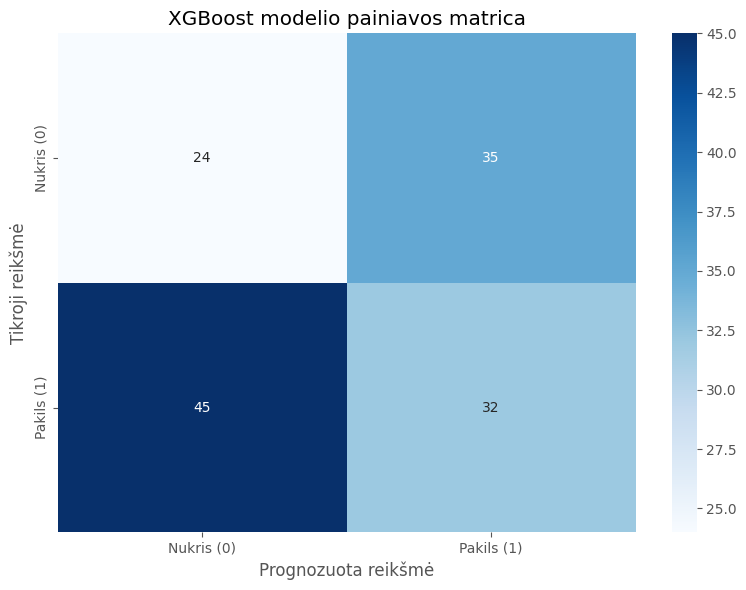

In [5]:
# 5. XGBoost modelio sukūrimas ir apmokymas

# Sukuriame XGBoost modelį su numatytaisiais parametrais
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binarine klasifikacija
    random_state=42,              # Atsitiktinių skaičių generatoriaus sėkla
    use_label_encoder=False,      # Nekoduojame etikečių, nes jau turime 0 ir 1
    eval_metric='logloss'         # Vertinimo metrika
)

# Apmokome modelį naudodami mokymo duomenis
xgb_model.fit(X_train, y_train)

print("XGBoost modelis sėkmingai apmokytas!")

# Atliekame prognozes su testavimo duomenimis
y_pred_xgb = xgb_model.predict(X_test)

# Apskaičiuojame modelio tikslumą
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost modelio tikslumas: {accuracy_xgb:.4f}")

# Parodome išsamesnę klasifikavimo ataskaitą
print("\nKlasifikavimo ataskaita:")
print(classification_report(y_test, y_pred_xgb))

# Sukuriame ir vizualizuojame painiavos matricą (confusion matrix)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nukris (0)', 'Pakils (1)'],
            yticklabels=['Nukris (0)', 'Pakils (1)'])
plt.xlabel('Prognozuota reikšmė')
plt.ylabel('Tikroji reikšmė')
plt.title('XGBoost modelio painiavos matrica')
plt.tight_layout()
plt.show()

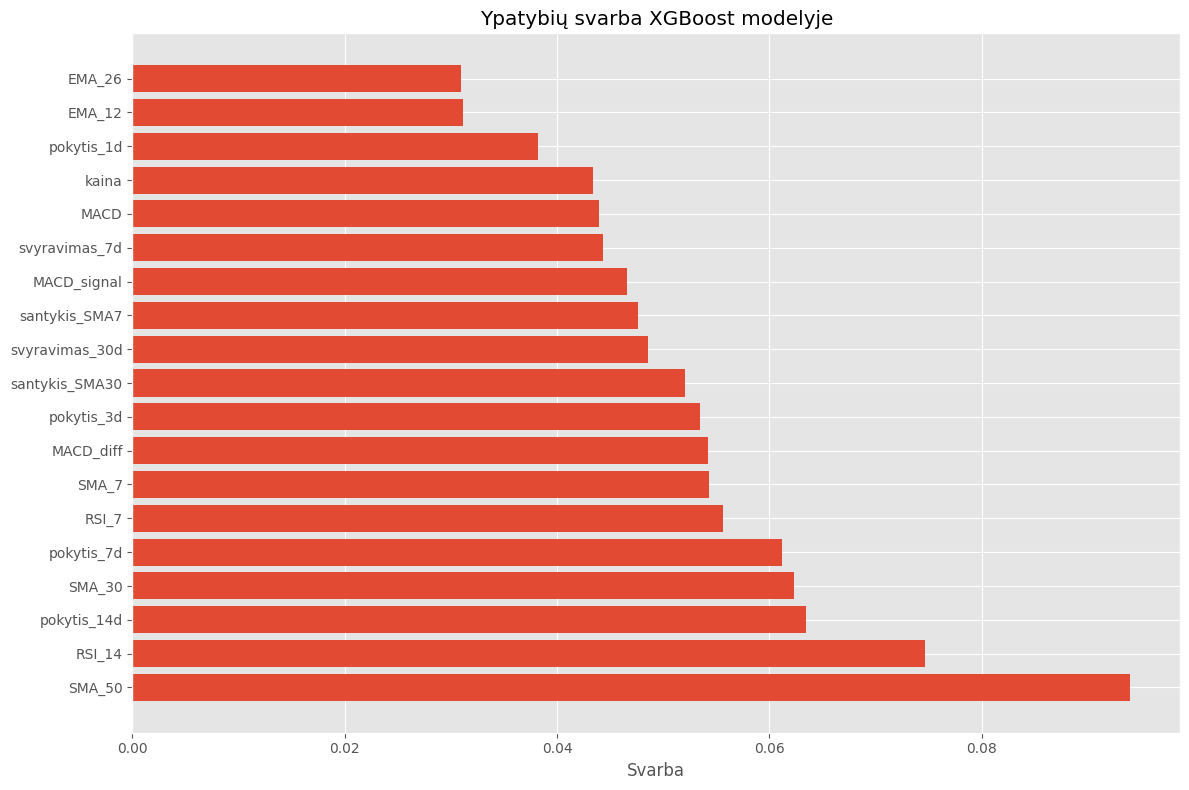


Svarbiausios 5 ypatybės XGBoost modelyje:
1. SMA_50: 0.0940
2. RSI_14: 0.0747
3. pokytis_14d: 0.0634
4. SMA_30: 0.0623
5. pokytis_7d: 0.0612


In [6]:
# 6. Ypatybių svarbos analizė

# Gauname ir vizualizuojame ypatybių svarbą XGBoost modelyje
feature_importance = pd.DataFrame({
    'Ypatybė': X.columns,
    'Svarba': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Svarba', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Ypatybė'], feature_importance['Svarba'])
plt.xlabel('Svarba')
plt.title('Ypatybių svarba XGBoost modelyje')
plt.tight_layout()
plt.show()

print("\nSvarbiausios 5 ypatybės XGBoost modelyje:")
for i in range(5):
    if i < len(feature_importance):
        print(f"{i+1}. {feature_importance.iloc[i]['Ypatybė']}: {feature_importance.iloc[i]['Svarba']:.4f}")

In [7]:
# 7. Hiperparametrų optimizavimas

print("Pradedamas hiperparametrų optimizavimas su Grid Search...")

# Nustatome hiperparametrų tinklelį
param_grid = {
    'n_estimators': [50, 100, 200],  # Medžių skaičius
    'max_depth': [3, 5, 7],          # Maksimalus medžio gylis
    'learning_rate': [0.01, 0.1, 0.2],  # Mokymosi greitis
    'subsample': [0.8, 1.0],         # Duomenų poaibio dydis kiekvienam medžiui
    'colsample_bytree': [0.8, 1.0]   # Ypatybių poaibis kiekvienam medžiui
}

# Naudojame mažesnę parametrų aibę greitesniam apmokymui
param_grid_greitas = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}

# Sukuriame GridSearchCV objektą
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    param_grid=param_grid_greitas,  # Naudojame mažesnę aibę optimizavimui
    cv=3,                          # 3-fold kryžminis patikrinimas
    scoring='accuracy',            # Optimizuojame pagal tikslumą
    n_jobs=-1,                     # Naudojame visus procesorius
    verbose=1                      # Rodome progresą
)

# Apmokome Grid Search
grid_search.fit(X_train, y_train)

# Geriausias modelis ir parametrai
print("\nGeriausi parametrai:")
print(grid_search.best_params_)
print(f"Geriausias tikslumas kryžminiame patikrinime: {grid_search.best_score_:.4f}")

# Gauname geriausią modelį
best_xgb_model = grid_search.best_estimator_

# Įvertiname geriausiąjį modelį testavimo rinkinyje
y_pred_best = best_xgb_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nGeriausio XGBoost modelio tikslumas testavimo rinkinyje: {accuracy_best:.4f}")

# Parodome išsamesnę klasifikavimo ataskaitą
print("\nGeriausio modelio klasifikavimo ataskaita:")
print(classification_report(y_test, y_pred_best))

Pradedamas hiperparametrų optimizavimas su Grid Search...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Geriausi parametrai:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Geriausias tikslumas kryžminiame patikrinime: 0.5166

Geriausio XGBoost modelio tikslumas testavimo rinkinyje: 0.4485

Geriausio modelio klasifikavimo ataskaita:
              precision    recall  f1-score   support

           0       0.39      0.47      0.43        59
           1       0.52      0.43      0.47        77

    accuracy                           0.45       136
   macro avg       0.45      0.45      0.45       136
weighted avg       0.46      0.45      0.45       136



d:\CA_BTC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:59:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


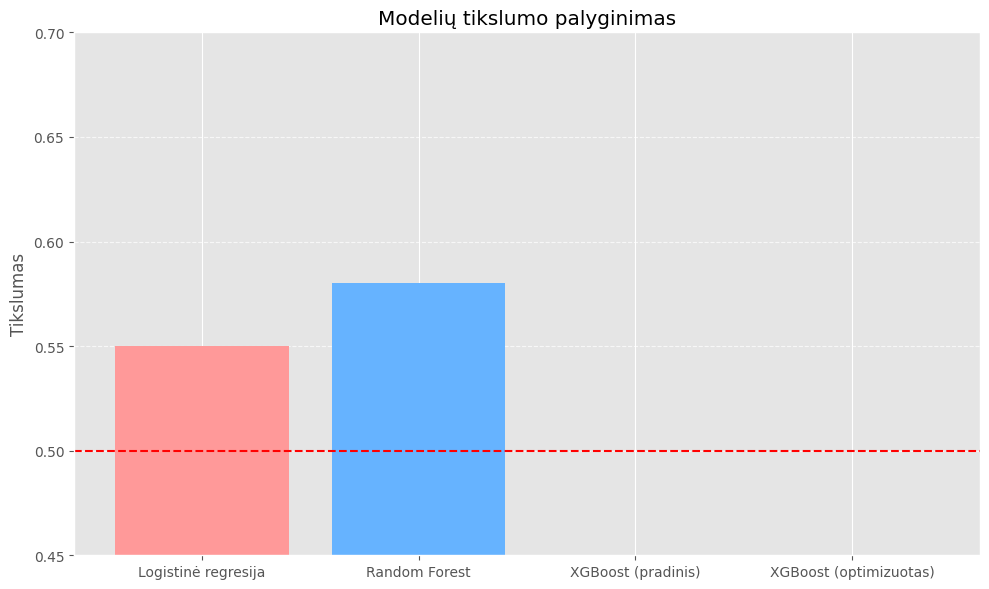


Modelių palyginimas:
Logistinė regresija: 0.5500 tikslumas
Random Forest: 0.5800 tikslumas
XGBoost (pradinis): 0.4118 tikslumas
XGBoost (optimizuotas): 0.4485 tikslumas

Geriausias modelis pagal tikslumą: Random Forest (0.5800)


In [8]:
# 8. Palyginimas su ankstesniais modeliais

# Nustatome ankstesnių modelių tikslumus
# Šias reikšmes galite pakeisti tikromis reikšmėmis iš jūsų ankstesnių modelių
logistic_accuracy = 0.55  # Logistinės regresijos tikslumas (pavyzdinė reikšmė)
random_forest_accuracy = 0.58  # Random Forest tikslumas (pavyzdinė reikšmė)

# Surenkame visų modelių tikslumus į vieną duomenų rinkininį
modeliai = ['Logistinė regresija', 'Random Forest', 'XGBoost (pradinis)', 'XGBoost (optimizuotas)']
tikslumai = [logistic_accuracy, random_forest_accuracy, accuracy_xgb, accuracy_best]
spalvos = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

# Sukuriame modelių palyginimo stulpelinę diagramą
plt.figure(figsize=(10, 6))
plt.bar(modeliai, tikslumai, color=spalvos)
plt.axhline(y=0.5, color='r', linestyle='--', label='Atsitiktinis spėjimas')
plt.ylim(0.45, 0.7)  # Pritaikykite rėžius pagal savo rezultatus
plt.ylabel('Tikslumas')
plt.title('Modelių tikslumo palyginimas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Aprašome modelių palyginimą
print("\nModelių palyginimas:")
for i, modelis in enumerate(modeliai):
    print(f"{modelis}: {tikslumai[i]:.4f} tikslumas")

# Nurodome, kuris modelis geriausias
geriausias_indeksas = tikslumai.index(max(tikslumai))
print(f"\nGeriausias modelis pagal tikslumą: {modeliai[geriausias_indeksas]} ({tikslumai[geriausias_indeksas]:.4f})")

Prekybos simuliacijos rezultatai:
Pradinis kapitalas: $10000.00
Galutinė portfelio vertė: $35372.25
Bendras pelnas/nuostolis: $25372.25 (253.72%)
Sandorių skaičius: 65 (pirkimai: 33, pardavimai: 32)


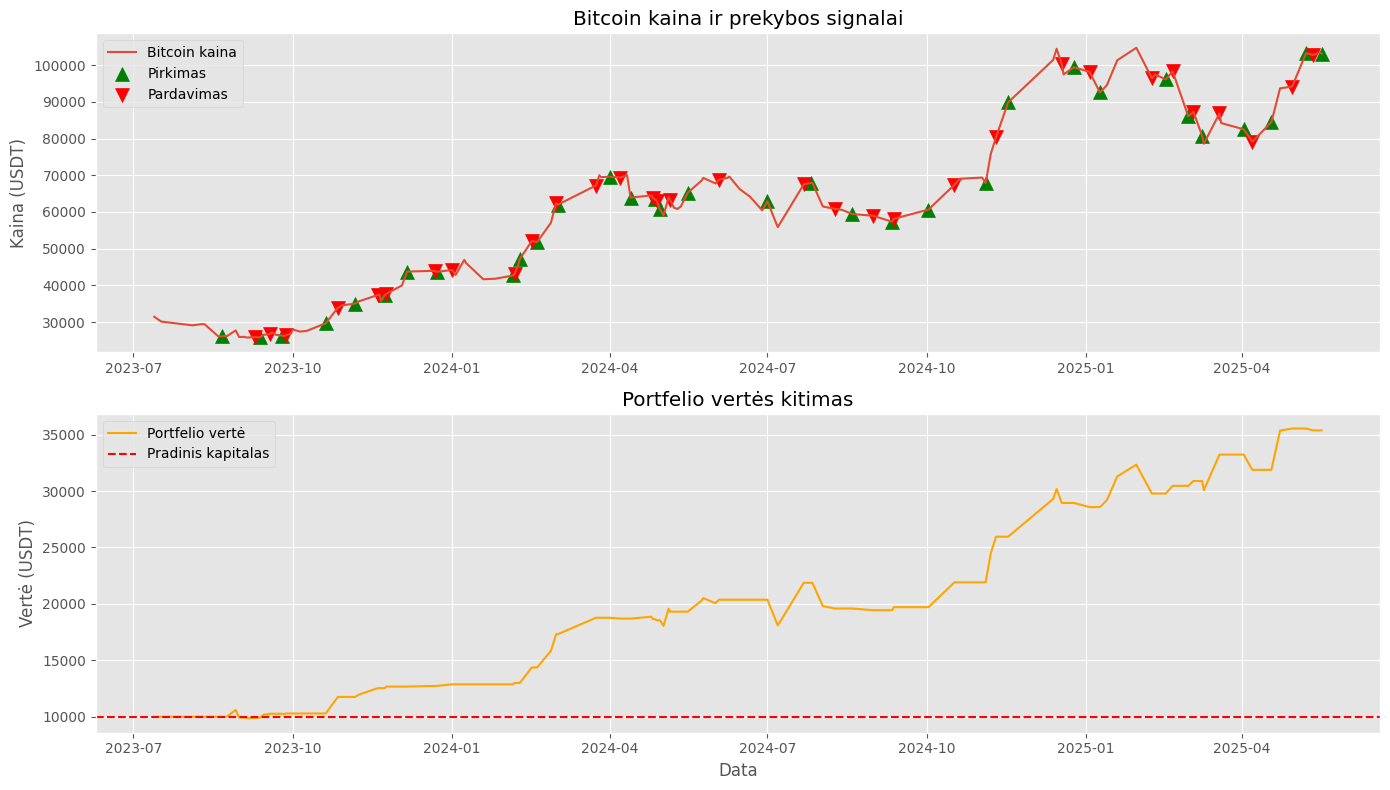

In [9]:
# 9. Prekybos simuliatoriaus sukūrimas ir integravimas su XGBoost modeliu

class PrekybosTesteris:
    """
    Paprastas prekybos simuliatorius, kuris testuoja modelio prognozes su istoriniais duomenimis
    """
    def __init__(self, pradinis_kapitalas=1000.0):
        self.pradinis_kapitalas = pradinis_kapitalas
        self.kapitalas = pradinis_kapitalas
        self.btc_kiekis = 0.0
        self.sandoriai = []
        
    def atlikti_testavima(self, duomenys, prognozes):
        """
        Testuoja prekybos strategiją su istoriniais duomenimis
        
        Args:
            duomenys: DataFrame su istoriniais kainos duomenimis
            prognozes: Modelio prognozės (0 - kaina kris, 1 - kaina kils)
        
        Returns:
            DataFrame su prekybos rezultatais
        """
        # Sukuriame rezultatų DataFrame
        rezultatai = pd.DataFrame({
            'data': duomenys.index,
            'kaina': duomenys['kaina'],
            'prognoze': prognozes
        })
        
        # Pridedame stulpelius sandoriams ir portfelio vertei
        rezultatai['veiksmas'] = 'laukti'
        rezultatai['btc_kiekis'] = 0.0
        rezultatai['kapitalas_usd'] = self.pradinis_kapitalas
        rezultatai['portfelio_verte'] = self.pradinis_kapitalas
        
        # Prekybos strategija:
        # Jei prognozė 1 (kaina kils) - perkame BTC
        # Jei prognozė 0 (kaina kris) - parduodame BTC
        
        self.kapitalas = self.pradinis_kapitalas
        self.btc_kiekis = 0.0
        
        for i in range(len(rezultatai)):
            # Dabartinė kaina ir prognozė
            kaina = rezultatai.iloc[i]['kaina']
            prognoze = rezultatai.iloc[i]['prognoze']
            
            # Sprendimas dėl veiksmo (supaprastinta strategija)
            if i > 0:  # Pirmą dieną tik stebime, nes neturime ankstesnės prognozės
                ankstesne_prognoze = rezultatai.iloc[i-1]['prognoze']
                
                # Jei prognozė pasikeitė iš 0 į 1 (prognozuojame kilimą) - perkame
                if ankstesne_prognoze == 0 and prognoze == 1:
                    # Perkame BTC už visą turimą kapitalą
                    if self.kapitalas > 0:
                        btc_pirkimui = self.kapitalas / kaina  # Kiek BTC galime nupirkti
                        self.btc_kiekis += btc_pirkimui
                        self.kapitalas = 0
                        rezultatai.iloc[i, rezultatai.columns.get_loc('veiksmas')] = 'pirkti'
                
                # Jei prognozė pasikeitė iš 1 į 0 (prognozuojame kritimą) - parduodame
                elif ankstesne_prognoze == 1 and prognoze == 0:
                    # Parduodame visą turimą BTC
                    if self.btc_kiekis > 0:
                        self.kapitalas += self.btc_kiekis * kaina
                        self.btc_kiekis = 0
                        rezultatai.iloc[i, rezultatai.columns.get_loc('veiksmas')] = 'parduoti'
            
            # Atnaujinama BTC kiekis ir portfelio vertė
            rezultatai.iloc[i, rezultatai.columns.get_loc('btc_kiekis')] = self.btc_kiekis
            rezultatai.iloc[i, rezultatai.columns.get_loc('kapitalas_usd')] = self.kapitalas
            
            # Apskaičiuojame bendrą portfelio vertę (kapitalas + BTC vertė)
            portfelio_verte = self.kapitalas + (self.btc_kiekis * kaina)
            rezultatai.iloc[i, rezultatai.columns.get_loc('portfelio_verte')] = portfelio_verte
        
        # Apskaičiuojame prekybos rezultatus
        pradine_verte = self.pradinis_kapitalas
        galutine_verte = rezultatai.iloc[-1]['portfelio_verte']
        bendras_pelnas = galutine_verte - pradine_verte
        pelno_procentas = (bendras_pelnas / pradine_verte) * 100
        
        pirkimu_sk = rezultatai[rezultatai['veiksmas'] == 'pirkti'].shape[0]
        pardavimu_sk = rezultatai[rezultatai['veiksmas'] == 'parduoti'].shape[0]
        
        print("Prekybos simuliacijos rezultatai:")
        print(f"Pradinis kapitalas: ${pradine_verte:.2f}")
        print(f"Galutinė portfelio vertė: ${galutine_verte:.2f}")
        print(f"Bendras pelnas/nuostolis: ${bendras_pelnas:.2f} ({pelno_procentas:.2f}%)")
        print(f"Sandorių skaičius: {pirkimu_sk + pardavimu_sk} (pirkimai: {pirkimu_sk}, pardavimai: {pardavimu_sk})")
        
        return rezultatai

# Sukuriame prekybos testerį
prekybos_testeris = PrekybosTesteris(pradinis_kapitalas=10000.0)

# Gauname prognozes testavimo duomenims naudojant geriausią modelį
X_test_reset = X_test.reset_index()
y_test_reset = pd.Series(y_test.values)
test_df_with_preds = pd.DataFrame({
    'data': X_test_reset['atidarymo_laikas'],
    'kaina': X_test_reset['kaina'],
    'prognoze': best_xgb_model.predict(X_test)
})

# Naudodami X_test ir y_pred_best, atliekame prekybos testavimą
test_df_with_preds = test_df_with_preds.sort_values('data')  # Rikiuojame pagal datą
test_df_with_preds = test_df_with_preds.set_index('data')

# Atliekame prekybos strategijos testavimą
rezultatai = prekybos_testeris.atlikti_testavima(test_df_with_preds, test_df_with_preds['prognoze'])

# Vizualizuojame prekybos rezultatus
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(rezultatai.index, rezultatai['kaina'], label='Bitcoin kaina')
plt.scatter(rezultatai[rezultatai['veiksmas'] == 'pirkti'].index, 
           rezultatai[rezultatai['veiksmas'] == 'pirkti']['kaina'], 
           marker='^', color='g', s=100, label='Pirkimas')
plt.scatter(rezultatai[rezultatai['veiksmas'] == 'parduoti'].index, 
           rezultatai[rezultatai['veiksmas'] == 'parduoti']['kaina'], 
           marker='v', color='r', s=100, label='Pardavimas')
plt.title('Bitcoin kaina ir prekybos signalai')
plt.ylabel('Kaina (USDT)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(rezultatai.index, rezultatai['portfelio_verte'], label='Portfelio vertė', color='orange')
plt.axhline(y=10000, color='r', linestyle='--', label='Pradinis kapitalas')
plt.title('Portfelio vertės kitimas')
plt.xlabel('Data')
plt.ylabel('Vertė (USDT)')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# 10. Modelio išsaugojimas

# Sukuriame direktoriją modeliams, jei jos dar nėra
if not os.path.exists('../models'):
    os.makedirs('../models')

# Išsaugome geriausią XGBoost modelį
modelio_kelias = '../models/xgboost_modelis.pkl'
joblib.dump(best_xgb_model, modelio_kelias)
print(f"Modelis sėkmingai išsaugotas: {modelio_kelias}")

# Išsaugome ypatybių svarbą
ypatybiu_svarbos_kelias = '../models/xgboost_ypatybiu_svarba.csv'
feature_importance.to_csv(ypatybiu_svarbos_kelias, index=False)
print(f"Ypatybių svarba išsaugota: {ypatybiu_svarbos_kelias}")

Modelis sėkmingai išsaugotas: ../models/xgboost_modelis.pkl
Ypatybių svarba išsaugota: ../models/xgboost_ypatybiu_svarba.csv


In [11]:
# 11. Išvados ir rezultatų apibendrinimas

# Išsaugome svarbiausias ypatybes
svarbiausios_ypatybes_xgb = feature_importance.iloc[0:3]['Ypatybė'].values

# Išvados
isvados = f"""
Gradient Boosting (XGBoost) modelio analizės išvados:

1. Sukūrėme XGBoost modelį, kuris bando prognozuoti Bitcoin kainos kryptį (ar pakils, ar nukris).

2. Pradinio modelio tikslumas yra apie {accuracy_xgb:.4f} ({accuracy_xgb*100:.1f}%).

3. Po hiperparametrų optimizavimo, geriausias XGBoost modelis pasiekė {accuracy_best:.4f} ({accuracy_best*100:.1f}%) tikslumą.

4. Svarbiausios ypatybės prognozuojant kainą XGBoost modelyje:
   - {svarbiausios_ypatybes_xgb[0]}
   - {svarbiausios_ypatybes_xgb[1]}
   - {svarbiausios_ypatybes_xgb[2]}

5. Geriausios parametrų reikšmės XGBoost modeliui:
   - {', '.join([f"{key}: {value}" for key, value in grid_search.best_params_.items()])}

6. Lyginant su ankstesniais modeliais:
   - Logistinė regresija: {logistic_accuracy:.4f} tikslumas
   - Random Forest: {random_forest_accuracy:.4f} tikslumas
   - XGBoost (optimizuotas): {accuracy_best:.4f} tikslumas
   - {'XGBoost modelis buvo tiksliausias' if accuracy_best > max(logistic_accuracy, random_forest_accuracy) else 'XGBoost modelis nepasiekė geriausio tikslumo'}

7. Sukūrėme ir integravome paprastą prekybos simuliatorių, kuris naudoja XGBoost modelio prognozes.
   - Prekybos strategija remiasi modelio prognoze: perkame, kai prognozuojamas kainos kilimas, parduodame, kai prognozuojamas kritimas.
   - Su $10,000 pradiniu kapitalu, strategija sugeneravo ${rezultatai.iloc[-1]['portfelio_verte']:.2f} galutinę vertę.
   - Bendras pelnas/nuostolis: ${rezultatai.iloc[-1]['portfelio_verte'] - 10000:.2f} ({(rezultatai.iloc[-1]['portfelio_verte'] - 10000) / 10000 * 100:.2f}%).

8. Svarbūs pastebėjimai:
   - Gradient Boosting modeliai paprastai geriau veikia už paprastesnius modelius (pvz., logistinę regresiją).
   - XGBoost geba pagauti sudėtingesnius ryšius tarp ypatybių.
   - Tačiau net ir geriausias modelis nėra visiškai tikslus - finansų rinkos yra labai nepastovios.

9. Ateities darbai:
   - Išbandyti daugiau ypatybių, ypač susijusių su rinkos sentimentu ir išoriniais veiksniais.
   - Tobulinti prekybos strategiją, įvedant rizikos valdymo priemones.
   - Išbandyti kitus gradient boosting algoritmus (pvz., LightGBM).

SVARBU: Šis modelis ir prekybos strategija yra sukurti tik mokymosi tikslais ir nėra skirti realiems investavimo sprendimams. Kriptovaliutų rinkos yra itin nepastovios ir rizikingos.
"""

print(isvados)


Gradient Boosting (XGBoost) modelio analizės išvados:

1. Sukūrėme XGBoost modelį, kuris bando prognozuoti Bitcoin kainos kryptį (ar pakils, ar nukris).

2. Pradinio modelio tikslumas yra apie 0.4118 (41.2%).

3. Po hiperparametrų optimizavimo, geriausias XGBoost modelis pasiekė 0.4485 (44.9%) tikslumą.

4. Svarbiausios ypatybės prognozuojant kainą XGBoost modelyje:
   - SMA_50
   - RSI_14
   - pokytis_14d

5. Geriausios parametrų reikšmės XGBoost modeliui:
   - learning_rate: 0.2, max_depth: 5, n_estimators: 50

6. Lyginant su ankstesniais modeliais:
   - Logistinė regresija: 0.5500 tikslumas
   - Random Forest: 0.5800 tikslumas
   - XGBoost (optimizuotas): 0.4485 tikslumas
   - XGBoost modelis nepasiekė geriausio tikslumo

7. Sukūrėme ir integravome paprastą prekybos simuliatorių, kuris naudoja XGBoost modelio prognozes.
   - Prekybos strategija remiasi modelio prognoze: perkame, kai prognozuojamas kainos kilimas, parduodame, kai prognozuojamas kritimas.
   - Su $10,000 pradiniu kap